In [1]:
# Import requeired packages

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [2]:
# Load data to pandas dataframe

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv("sample_submission.csv").dropna(how="all")
passenger_ids = test['PassengerId']

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


<Axes: >

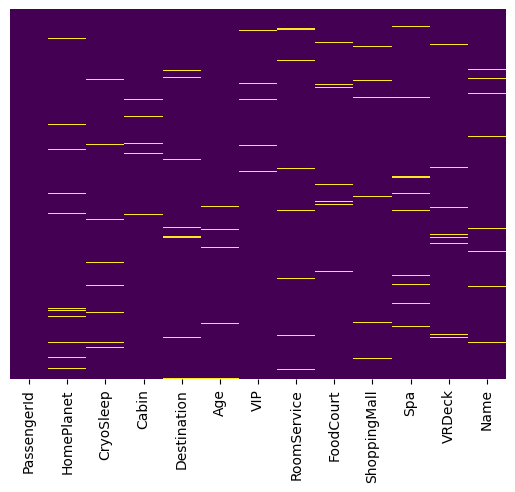

In [4]:
# Check missing values
sns.heatmap(train.isna(),yticklabels=False,cbar=False,cmap='viridis')
sns.heatmap(test.isna(),yticklabels=False,cbar=False,cmap='viridis')

In [5]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

Fill and drop NaN values

In [6]:
# Get mode for missing categorical values
mode_HomePlanet= train['HomePlanet'].mode()[0]
mode_Destinationt= train['Destination'].mode()[0]

# Fill missing and/or 0 values
train['HomePlanet'].fillna(mode_HomePlanet, inplace=True)
train['Destination'].fillna(mode_Destinationt, inplace=True)
train['CryoSleep'].fillna(False, inplace=True)
train['VIP'].fillna(False, inplace=True)
train['Cabin'].fillna(method='ffill', inplace=True)
train['VRDeck'].fillna(0, inplace=True)
train['RoomService'].fillna(0, inplace=True)
train['FoodCourt'].fillna(0, inplace=True)
train['ShoppingMall'].fillna(0, inplace=True)
train['Spa'].fillna(train['Spa'] == 0, inplace=True)
train['Age'].fillna(train['Age'].mean(), inplace=True)
#train[["Deck", "Cabin_num", "Side"]] = train["Cabin"].str.split("/", expand=True)

# Drop unnecessary columns and rows
train = train.drop('Cabin', axis=1)
train = train.drop('PassengerId', axis=1)
train = train.drop('Name', axis=1)
train = train.dropna()

C:\Users\ZZ07NN740\AppData\Local\Temp\ipykernel_17464\3651949783.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['HomePlanet'].fillna(mode_HomePlanet, inplace=True)
C:\Users\ZZ07NN740\AppData\Local\Temp\ipykernel_17464\3651949783.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

Convert values

In [7]:
# Convert object data to int

train['CryoSleep'] = train['CryoSleep'].astype(int)
train['VIP'] = train['VIP'].astype(int)
train['Transported'] = train['Transported'].astype(int)
train['Age'] = train['Age'].astype(int)
train['RoomService'] = train['RoomService'].astype(int)
train['FoodCourt'] = train['FoodCourt'].astype(int)
train['ShoppingMall'] = train['ShoppingMall'].astype(int)
train['Spa'] = train['Spa'].astype(int)
train['VRDeck'] = train['VRDeck'].astype(int)

Checking for outliers

<Axes: >

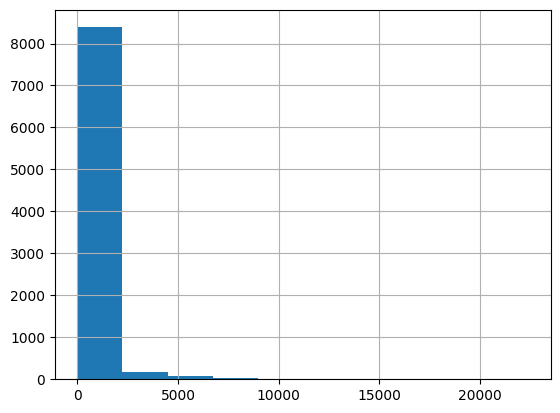

In [8]:
train["Spa"].hist()

In [9]:
train[train['VRDeck'] > 100 ]
# age < 62
# train[train['RoomService'] < 1000 ]
# train[train['FoodCourt'] < 1000 ]
# train[train['ShoppingMall'] < 800 ]
# train[train['Spa'] < 800 ]
# train[train['VRDeck'] < 1000 ]

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
3,Europa,0,TRAPPIST-1e,33,0,0,1283,371,3329,193,0
11,Europa,0,55 Cancri e,45,0,39,7295,589,110,124,1
12,Mars,0,TRAPPIST-1e,32,0,73,0,1123,0,113,1
17,Earth,0,55 Cancri e,24,0,0,1,0,0,637,0
20,Earth,0,55 Cancri e,14,0,412,0,1,0,679,0
...,...,...,...,...,...,...,...,...,...,...,...
8667,Europa,0,TRAPPIST-1e,29,0,0,2972,0,28,188,1
8669,Europa,0,55 Cancri e,26,0,0,8160,205,0,438,1
8683,Earth,0,TRAPPIST-1e,21,0,86,3,149,208,329,0
8687,Europa,0,TRAPPIST-1e,30,0,0,3208,0,2,330,1


In [10]:
# Remove outliers

train = train[train['RoomService'] < 1000]
train = train[train['FoodCourt'] < 1000]
train = train[train['ShoppingMall'] < 800]
train = train[train['Spa'] < 800]
train = train[train['VRDeck'] < 1000]

Test data

In [11]:
# Do the same preprocessing as we did for train data

mode_HomePlanet_test = train['HomePlanet'].mode()[0]
mode_Destinationt_test = train['Destination'].mode()[0]
test['HomePlanet'].fillna(mode_HomePlanet_test, inplace=True)
test['Destination'].fillna(mode_Destinationt_test, inplace=True)
test['CryoSleep'].fillna(False, inplace=True)
test['VIP'].fillna(False, inplace=True)
test['Cabin'].fillna(method='ffill', inplace=True)

test['VRDeck'].fillna(0, inplace=True)
test['RoomService'].fillna(0, inplace=True)
test['FoodCourt'].fillna(0, inplace=True)
test['ShoppingMall'].fillna(0, inplace=True)
test['Spa'].fillna(0, inplace=True)
test['Age'].fillna(test['Age'].mean(), inplace=True)

test = test.drop('PassengerId', axis=1)

test = test.drop('Name', axis=1)
test = test.drop('Cabin', axis=1)


test = test.dropna()

test['CryoSleep'] = test['CryoSleep'].astype(int)
test['VIP'] = test['VIP'].astype(int)
test['Age'] = test['Age'].astype(int)
test['RoomService'] = test['RoomService'].astype(int)
test['FoodCourt'] = test['FoodCourt'].astype(int)
test['ShoppingMall'] = test['ShoppingMall'].astype(int)
test['Spa'] = test['Spa'].astype(int)
test['VRDeck'] = test['VRDeck'].astype(int)

C:\Users\ZZ07NN740\AppData\Local\Temp\ipykernel_17464\1989308067.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['HomePlanet'].fillna(mode_HomePlanet_test, inplace=True)
C:\Users\ZZ07NN740\AppData\Local\Temp\ipykernel_17464\1989308067.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

Train and evulate model

In [22]:
# Split the train data to test and train dataset

X_train, X_test, y_train, y_test = train_test_split(train.drop('Transported',axis=1), 
                                                    train['Transported'], test_size=0.30, 
                                                    random_state=101)

In [23]:
# Convert categorical data to numbers

X_train_encoded = pd.get_dummies(X_train, columns=['HomePlanet', 'Destination'])
X_test_encoded = pd.get_dummies(X_test, columns=['HomePlanet', 'Destination'])
df_prediction_encoded = pd.get_dummies(test, columns=['HomePlanet', 'Destination'])

Check correlation

Text(0.5, 1.0, 'train.corr()')

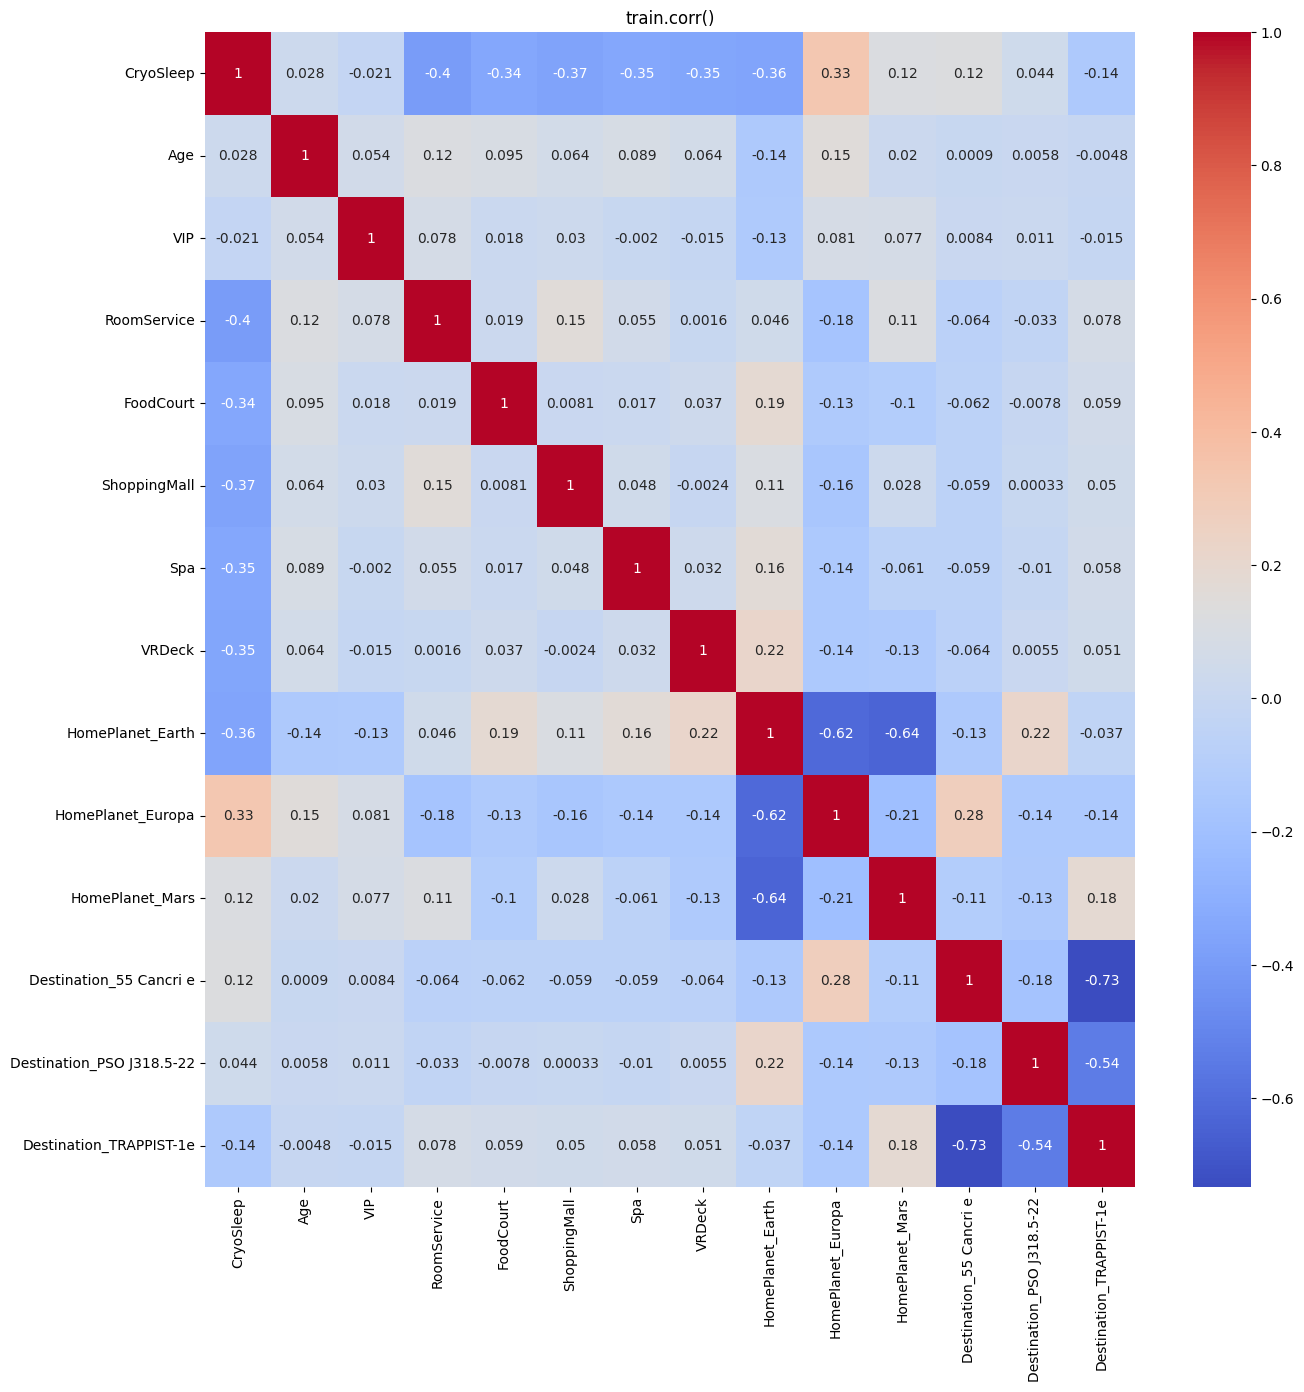

In [25]:
plt.figure(figsize=(15,15))
sns.heatmap(X_train_encoded.corr(),cmap='coolwarm', annot=True)
plt.title('train.corr()')

Trying different models

In [26]:
# Logistic regression

log_reg = LogisticRegression()
log_reg.fit(X_train_encoded, y_train)

c:\Users\ZZ07NN740\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
# Make the prediction and print the necessary metrics

predictions = log_reg.predict(X_test_encoded)
print(classification_report(y_test,predictions))
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       750
           1       0.79      0.81      0.80      1079

    accuracy                           0.77      1829
   macro avg       0.76      0.76      0.76      1829
weighted avg       0.76      0.77      0.77      1829

[[522 228]
 [200 879]]


In [28]:
# Check accuracy as we need this for the competition

accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7659923455440131


In [29]:
# Decision Tree Classifier with Grid Search CV

dtree = DecisionTreeClassifier()

param_grid = [{'min_samples_split': [5, 10, 15, 20], 'max_depth': [3, 6, 9, 12]}]

grid_search = GridSearchCV(estimator=dtree,
                          param_grid=param_grid,
                          scoring="top_k_accuracy",
                          cv=5,
                          return_train_score=True)

# fit the grid search
grid_search.fit(X_train_encoded, y_train)

c:\Users\ZZ07NN740\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1777: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
c:\Users\ZZ07NN740\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1777: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
c:\Users\ZZ07NN740\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1777: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and is therefore meaningless.
  warnings.warn(
c:\Users\ZZ07NN740\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_ranking.py:1777: UndefinedMetricWarning: 'k' (2) greater than or equal to 'n_classes' (2) will result in a perfect score and

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [3, 6, 9, 12],
                          'min_samples_split': [5, 10, 15, 20]}],
             return_train_score=True, scoring='top_k_accuracy')

In [30]:
# Make the prediction and print the necessary metrics

dtc_tuned = grid_search.best_estimator_
dtc_tuned.fit(X_train_encoded, y_train)
predictions = dtc_tuned.predict(X_test_encoded)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7588846364133406


In [31]:
# Random Forest Classifier

model = RandomForestClassifier(n_estimators=500, max_depth=7, random_state=1)
# Test set prediction
model.fit(X_train_encoded, y_train)

# Make the prediction and print the necessary metrics

y_pred = model.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7681793329688354


In [32]:
# Gradient Boosting Classifier

gradient_class = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, random_state=42)
gradient_class.fit(X_train_encoded, y_train)

# Make the prediction and print the necessary metrics

y_pred = gradient_class.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7605248769819574


In [33]:
# LGBM Classifier

from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)

lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 62, 127]
}

lgb_grid_search = GridSearchCV(estimator=lgb, param_grid=lgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=60)
lgb_grid_search.fit(X_train_encoded, y_train)

lgb_best_params = lgb_grid_search.best_params_
print(f"Best parameters for LGBMClassifier: {lgb_best_params}")

lgb_best_model = LGBMClassifier(**lgb_best_params, random_state=42)
lgb_best_model.fit(X_train_encoded, y_train)

y_test = np.array(y_test)

# Make the prediction and print the necessary metrics

y_pred_lgb = lgb_best_model.predict(X_test_encoded)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f'Accuracy: {accuracy}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2465, number of negative: 1801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1355
[LightGBM] [Info] Number of data points in the train set: 4266, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.577825 -> initscore=0.313850
[LightGBM] [Info] Start training from score 0.313850
Best parameters for LGBMClassifier: {'learning_rate': 0.01, 'n_estimators': 200, 'num_leaves': 31}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2465, number of negative: 1801
[LightGBM] [Info] Auto-choosing row-wise multi-threading,

In [34]:
# Voting Classifier https://machinelearningmastery.com/voting-ensembles-with-python/

estimator = []
estimator.append(('Neural Network', MLPClassifier(max_iter = 10000) ))
estimator.append(('LogisticRegression', LogisticRegression(solver ='lbfgs', multi_class ='multinomial', max_iter = 200)))
estimator.append(('ExtraTreesClassifier', ExtraTreesClassifier() ))
estimator.append(('RandomForest', RandomForestClassifier() ))
#estimator.append(('KNN', KNeighborsClassifier() ))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('AdaBoostClassifier', AdaBoostClassifier() ))
estimator.append(('GradientBoostingClassifier', GradientBoostingClassifier() ))
estimator.append(('XGB', XGBClassifier() ))
estimator.append(('CatBoost', CatBoostClassifier(logging_level='Silent') ))

VC_hard = VotingClassifier(estimators = estimator, voting ='hard')
VC_hard.fit(X_train_encoded, y_train)

# Make the prediction and print the necessary metrics

y_pred = VC_hard.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

c:\Users\ZZ07NN740\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7774740295243302


Evaluate the best model for our test data

In [35]:
test_predictions_lgb = VC_hard.predict(df_prediction_encoded)
test_predictions_lgb = test_predictions_lgb.astype(bool)
test_predictions_lgb

array([ True, False,  True, ...,  True, False,  True])

In [36]:
# Save our prediction to the submission.csv

submission_lgb = pd.DataFrame({'PassengerId': passenger_ids, 'Transported': test_predictions_lgb})
submission_lgb.to_csv('submission_lgb.csv', index=False)

print(submission_lgb.head())

  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01        False
4     0023_01        False
